In [1]:
import sys
sys.path.append('../../')

In [2]:
import datas.income2023f as income2023f

Loading Data
Finished Loading Data


In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np

In [4]:
def preprocess(df):
    df = df.copy()
    return_y = False
    if 'income>50K' in df.columns:
        return_y = True
        y = np.array(list(df['income>50K']))
    df.drop(columns=['ID', 'income>50K'], inplace=True, errors='ignore')
    
    ret = [] #np.zeros(shape=[len(df), len(df.columns)], dtype=np.float32)
    
    for i, row in df.iterrows():
        dp = [
            row.age,
            *row.workclass,
            row.fnlwgt,
            *row.education,
            row['education.num'],
            *row['marital.status'],
            *row.occupation,
            *row.relationship,
            *row.race,
            *row.sex,
            row['capital.gain'],
            row['capital.loss'],
            row['hours.per.week'],
            *row['native.country']
        ]
        dp.extend(np.multiply(dp, dp))
        ret.append(dp)
    
    if return_y:
        return np.array(ret), y
    return np.array(ret)

In [5]:
train, train_y = preprocess(income2023f.train_preprocessed.iloc[income2023f.train_training_partition])
validation, validation_y = preprocess(income2023f.train_preprocessed.iloc[income2023f.train_valdiation_partition])

In [6]:
knn = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=60, algorithm='brute', weights='distance')
)

In [7]:
knn.fit(train, train_y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(algorithm='brute', n_neighbors=60,
                                      weights='distance'))])

In [8]:
validation_pred = knn.predict_proba(validation)

In [9]:
import scikitplot as skplt

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

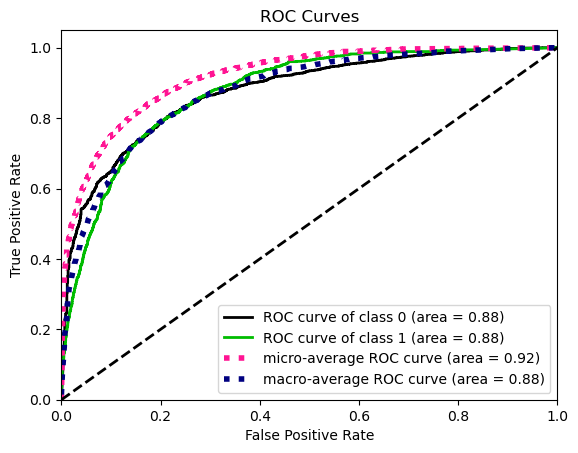

In [10]:
skplt.metrics.plot_roc(
    validation_y,
    validation_pred
)

In [11]:
test = preprocess(income2023f.test_preprocessed)
test_pred = knn.predict_proba(test)

In [12]:
import pandas as pd
pd.DataFrame(
    {
        'ID': list(range(1, 23843)),
        'Prediction':test_pred[:,1] # index one for predictions on positives...
    }
).to_csv('./knn_test_predictions.csv', index=False)